## Packages

# Background
[PyMC3](https://www.pymc.io/welcome.html) (now simply PyMC) is a Bayesian modelling package that enables us to carry out [Bayesian inference](https://en.wikipedia.org/wiki/Bayesian_inference) easily as Data Scientists.

Under the hood, PyMC3 uses the method of [Markov Chain Monte Carlo (MCMC)](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) to compute the posterior distribution. This method is quite complex.  The post [here](https://towardsdatascience.com/a-zero-math-introduction-to-markov-chain-monte-carlo-methods-dcba889e0c50) explains the topic very well.

You may be wondering why does the package use MCMC? Well this is to get around the intractability of computing the normalising constant in Bayes' theorem:
$$
P(H \mid D)=\frac{P(H) P(D \mid H)}{P(D)}
$$

Where $P(H \mid D)$ is the posterior, $P(H)$ is the prior, $P(D \mid H)$ is the likelihood and $P(D)$ is the normalising constant defined as:
$$
P(D)=\int P(H) P(D \mid H) d H
$$

For many problems this integral either hasn't got a closed form solution or is not computational possible to calculate. Hence, methods such as MCMC have been developed to solve this issue and allow us to use Bayesian methods.



#PyPC3 and MCMC implementation of Bayes Regression

In PyMC3, MCMC (Markov Chain Monte Carlo) is used to estimate the posterior distribution of a model's parameters given observed data. 

To use MCMC in PyMC3, you need to define a probabilistic model using Python code. This model specifies the likelihood of the data given the model parameters, as well as any prior distributions for the parameters. 

Once you have defined the model, you can run the MCMC algorithm to generate samples from the posterior distribution. PyMC3 provides a variety of MCMC algorithms to choose from, including Metropolis-Hastings, NUTS (No-U-Turn Sampler), and Hamiltonian Monte Carlo. 

To run MCMC in PyMC3, you need to create a `Model` object and define your model as a `with` block. Within this block, you can define your variables using PyMC3's `Distribution` classes, specify your likelihood function, and add any prior distributions. 

After defining the model, you can use PyMC3's `sample()` function to generate MCMC samples from the posterior distribution. This function takes a number of arguments, including the number of samples to generate, the MCMC algorithm to use, and any tuning parameters for the algorithm. 

Once the MCMC samples are generated, you can use PyMC3's built-in functions to visualize and analyze the posterior distribution. For example, you can use `plot_trace()` to visualize the traces of the MCMC chains, or `summary()` to get summary statistics for the posterior distribution. 

Overall, PyMC3 makes it relatively straightforward to define and run MCMC algorithms for probabilistic models in Python.

# Overview: Bayesian vs Frequentist Regression
The key difference between the Frequentist and Bayesian approach to Regression is in how they treat the parameters. In Frequentist statistics, the parameters of a Linear Regression model are fixed, whereas in Bayesian statistics they are random variables.

Frequentist use the method of **Maximum Likelihood Estimation (MLE)** to deduce the values of the Linear Regression model. The result of MLE is a single-fixed value for each parameter.

However, in the Bayesian world your parameters have a distribution of values that they can be with a certain probability. This distribution is then updated using more data, so that we can become more certain about the values the parameters can take. 

# Example of PyMC3 and MCMC usage to implement Bayesian Regression

In [1]:
# Import pyMC3 and also arviz for visualisation
import pymc as pm
import arviz as az

In [2]:
# Import the other data science packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from scipy.stats import norm
import statsmodels.formula.api as smf

## Data

In [3]:
# Generate data
x, y = datasets.make_regression(n_samples=10_000,
                                n_features=1,
                                noise=10,
                                bias=5)

In [4]:
# Create the dataframe
data = pd.DataFrame(list(zip(x.flatten(), y)),
               columns =['x', 'y'])
data

,x,y
0,0.746543,0.624074
1,0.618673,11.109527
2,-1.565275,-38.075863
3,1.008637,22.840339
4,-0.309141,-3.406548
...,...,...
9995,-0.939010,-8.274751
9996,-1.086738,-30.438734
9997,0.660618,23.435115
9998,-0.473558,-10.313743


## OLS Fit

In [5]:
# OLS line
formula = 'y ~ x'
results = smf.ols(formula, data=data).fit()
results.params

Intercept     4.821968
x            20.321963
dtype: float64

In [6]:
# Get the residuals
results.resid.std()

9.919061328513763

In [7]:
# Get our equation of the OLS line
inter = results.params['Intercept']
slope = results.params['x']
x_vals = np.arange(min(x), max(x), 0.1)
ols_line = inter + slope * x_vals

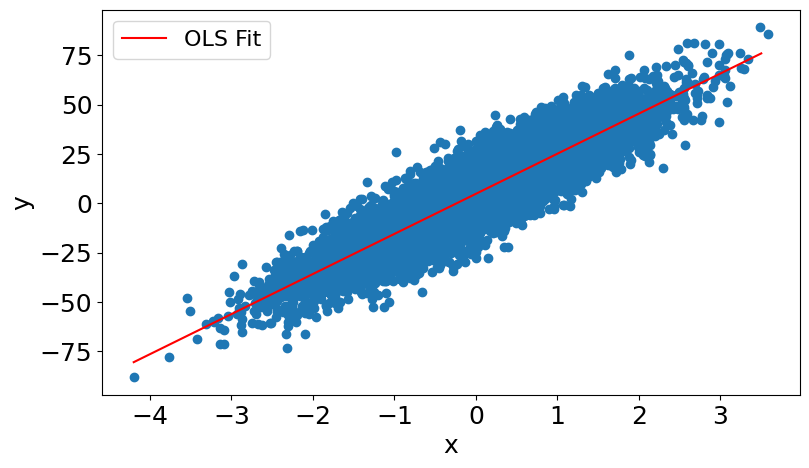

In [8]:
# Plot the target against our feature with the OLS regression
fig, ax = plt.subplots(figsize=(9,5))
ax.scatter(data['x'], data['y'])
ax.plot(x_vals, ols_line,label='OLS Fit', color='red')
ax.ticklabel_format(style='plain')
plt.xlabel('x',fontsize=18)
plt.ylabel('y',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=16)
plt.savefig('pic.png')
plt.show()

## PyMC3 Model

### 100 Samples

In [9]:
# Start our model
with pm.Model() as model:

    # Define the priors on each parameter:
    grad = pm.Uniform("grad",
                      lower=results.params['x']*0.5,
                      upper=results.params['x']*1.5)
    
    inter = pm.Uniform("inter",
                       lower=results.params['Intercept']*0.5,
                       upper=results.params['Intercept']*1.5)
    
    sigma = pm.Uniform("sigma",
                       lower=results.resid.std()*0.5,\
                       upper=results.resid.std()*1.5)
    
    # Linear regression line
    mean = inter + grad*data['x']
    
    # Describe the distribution of our conditional output
    y = pm.Normal('y', mu = mean, sigma = sigma, observed = data['y'])

    # Run the sampling using pymc3 for 1000 samples
    trace_100 = pm.sample(100,return_inferencedata=True)

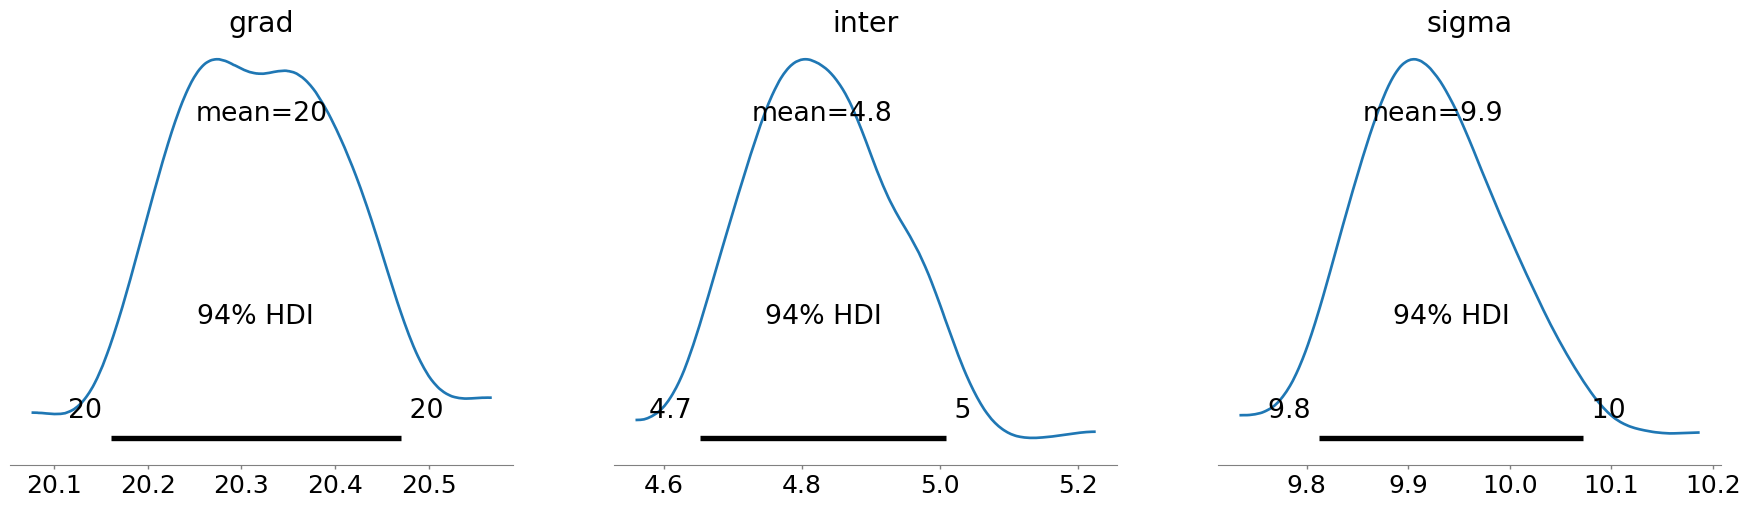

In [10]:
with model:
    az.plot_posterior(trace_100,
                      var_names=['grad', 'inter', 'sigma'],
                      textsize=18,
                      point_estimate='mean',
                      rope_color='black')

This simulation was only done with 100 samples from our data. As with Bayesian methods, we become more certain with more data.

### 10,000 Samples

In [11]:
# Start our model
with pm.Model() as model:

    # Define the priors on each parameter:
    grad = pm.Uniform("grad",
                      lower=results.params['x']*0.5,
                      upper=results.params['x']*1.5)
    
    inter = pm.Uniform("inter",
                       lower=results.params['Intercept']*0.5,
                       upper=results.params['Intercept']*1.5)
    
    sigma = pm.Uniform("sigma",
                       lower=results.resid.std()*0.5,
                       upper=results.resid.std()*1.5)
    
    # Linear regression line
    mean = inter + grad*data['x']
    
    # Describe the distribution of our conditional output
    y = pm.Normal('y', mu = mean, sigma = sigma, observed = data['y'])

    # Run the sampling using pymc3 for 10,000 samples
    trace_10_000 = pm.sample(10_000,return_inferencedata=True)

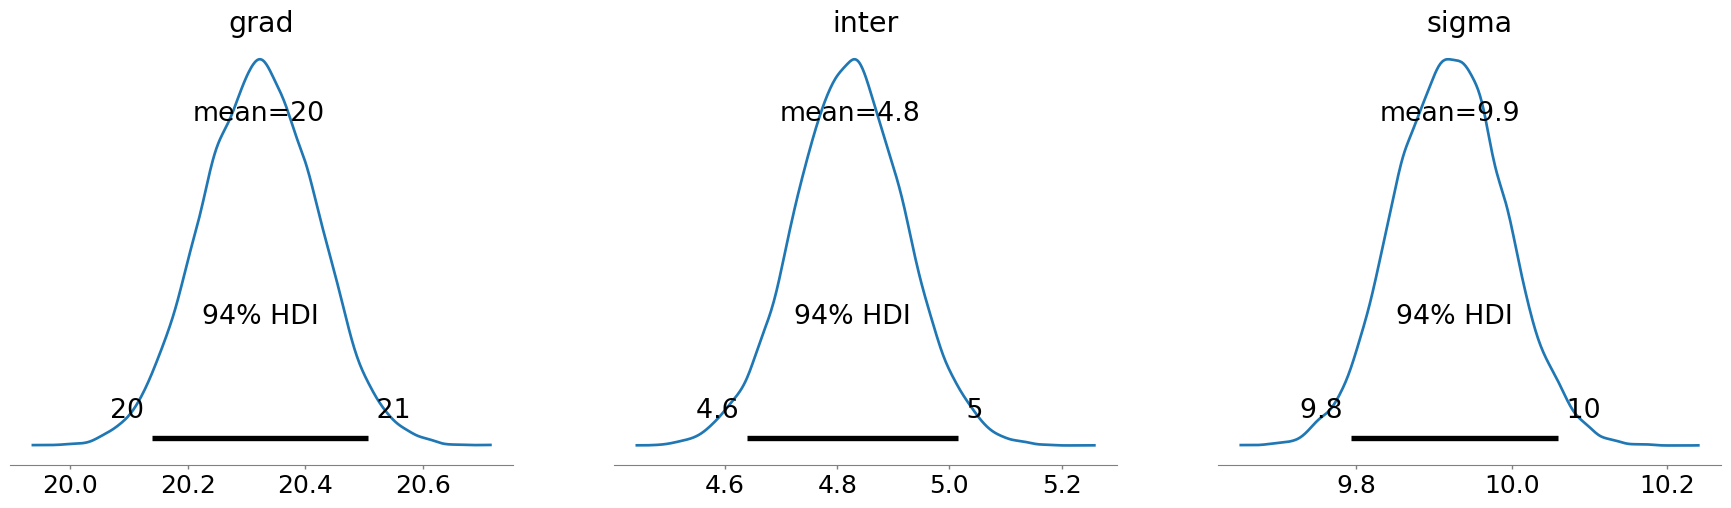

In [12]:
with model:
    az.plot_posterior(trace_10_000,
                      var_names=['grad', 'inter', 'sigma'],
                      textsize=18,
                      point_estimate='mean',
                      rope_color='black')

The mean predictions haven’t changed, but the distributions as a whole have become smoother and tighter as we are more certain of the distribution of the parameters.

# MCMC sampling distributions

MCMC, or Markov Chain Monte Carlo, is a commonly used method for sampling from complex probability distributions. The basic idea is to use a random walk to explore the space of possible values, and to accept or reject each step based on a criterion that ensures the correct distribution is being sampled. Here is a simple example of MCMC sampling using Python code:

Acceptance rate:  0.7036


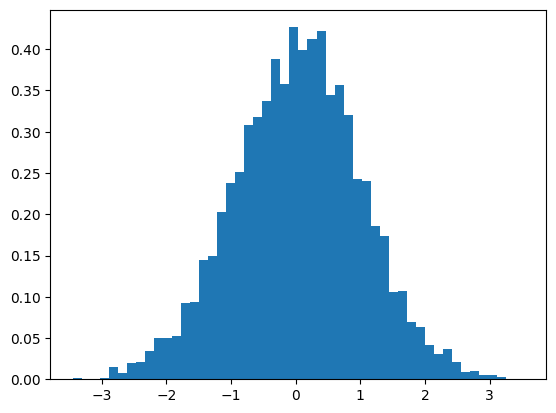

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Define the target distribution as a Gaussian
def target_distribution(x):
    return np.exp(-0.5*x**2)

# Define the proposal distribution as a Gaussian with mean 0 and standard deviation 1
def proposal_distribution(x):
    return np.random.normal(x, 1)

# Set the number of samples to generate
num_samples = 10000

# Initialize the MCMC chain with a random starting value
current_value = np.random.normal(0, 1)

# Initialize lists to store the samples and acceptance rates
samples = [current_value]
acceptance_rates = []

# Generate the samples
for i in range(num_samples):
    # Propose a new value from the proposal distribution
    proposed_value = proposal_distribution(current_value)
    
    # Calculate the acceptance ratio
    acceptance_ratio = target_distribution(proposed_value)/target_distribution(current_value)
    
    # Accept or reject the proposed value based on the acceptance ratio
    if np.random.uniform() < acceptance_ratio:
        current_value = proposed_value
        samples.append(current_value)
        acceptance_rates.append(1)
    else:
        samples.append(current_value)
        acceptance_rates.append(0)

# Print the acceptance rate
print("Acceptance rate: ", np.mean(acceptance_rates))

# Plot the histogram of the samples
plt.hist(samples, bins=50, density=True)
plt.show()


In this example, we are sampling from a Gaussian distribution with mean 0 and standard deviation 1. The target distribution is defined as a Gaussian with the same parameters, and the proposal distribution is also a Gaussian with mean 0 and standard deviation 1. We initialize the MCMC chain with a random starting value, and then generate a sequence of samples by proposing new values from the proposal distribution and accepting or rejecting them based on the acceptance ratio. Finally, we plot the histogram of the samples to see how well they match the target distribution.

In [1]:
import numpy as np
import plotly.graph_objs as go

# define the target distribution
def target_dist(x):
    return np.exp(-(x - 4) ** 2 / 4) + np.exp(-(x + 4) ** 2 / 4)

# define the MCMC algorithm
def mcmc_sampler(initial_state, n_steps):
    samples = [initial_state]
    for i in range(n_steps):
        current_state = samples[-1]
        proposed_state = np.random.normal(current_state, 1)
        acceptance_ratio = min(1, target_dist(proposed_state) / target_dist(current_state))
        if np.random.rand() < acceptance_ratio:
            samples.append(proposed_state)
        else:
            samples.append(current_state)
    return samples

# define the number of steps and initial state
n_steps = 1000
initial_state = 0

# run the MCMC sampler
samples = mcmc_sampler(initial_state, n_steps)

# plot the results
fig = go.Figure()
fig.add_trace(go.Histogram(x=samples, nbinsx=50))
fig.update_layout(
    title="MCMC Sampling",
    xaxis_title="Samples",
    yaxis_title="Frequency",
)
fig.show()


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler



In [2]:
!pip install scikit-learn==1.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 12.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [4]:
boston = load_boston()
data = boston.data
target = boston.target

# Scaling the features
scaler = StandardScaler()
data = scaler.fit_transform(data)


/usr/local/lib/python3.9/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

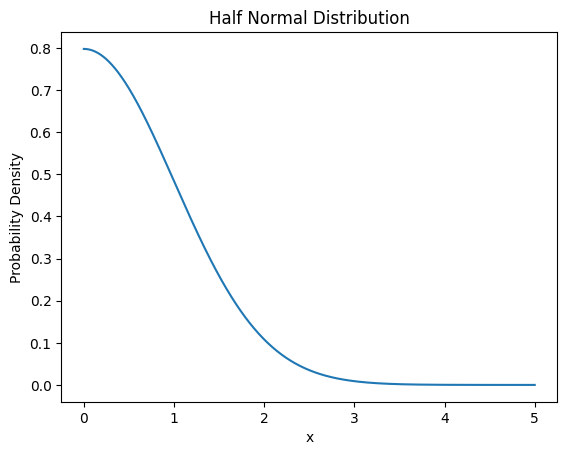

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Define the mean and standard deviation of the normal distribution
mu = 0
sigma = 1

# Create a range of x-values from 0 to 5
x = np.linspace(0, 5, 1000)

# Calculate the PDF of the half normal distribution
pdf = np.sqrt(2/np.pi) * np.exp(-x**2 / (2*sigma**2)) / sigma

# Plot the PDF
plt.plot(x, pdf)
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title('Half Normal Distribution')
plt.show()

In [5]:
with pm.Model() as model:
    # Define priors
    beta = pm.Normal('beta', mu=0, sigma=10, shape=data.shape[1])
    alpha = pm.Normal('alpha', mu=0, sigma=10)

    # Define likelihood
    mu = alpha + pm.math.dot(data, beta)
    sigma = pm.HalfNormal('sigma', sigma=1)
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=target)

    # Inference
    trace = pm.sample(1000, tune=1000)


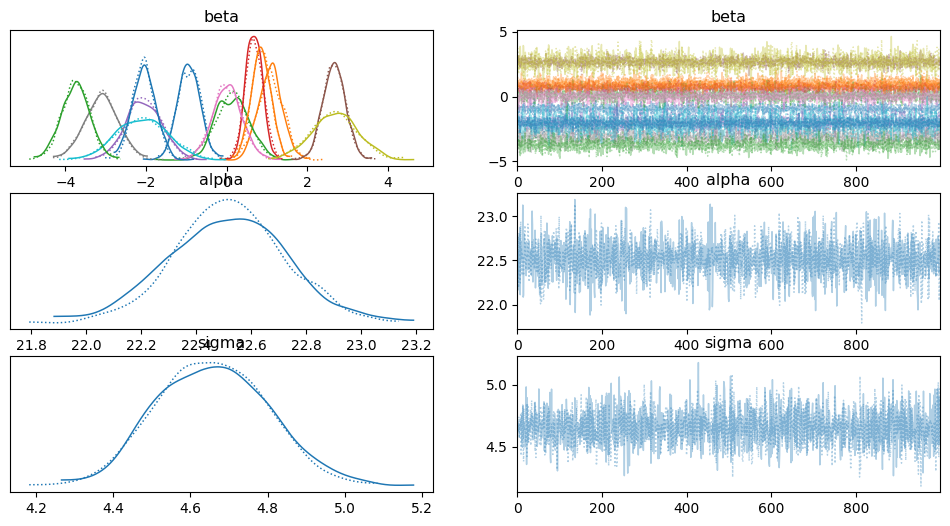

In [6]:
pm.plot_trace(trace)
plt.show()


In [9]:
beta.shape

TensorConstant{(1,) of 13}

KeyError: ignored

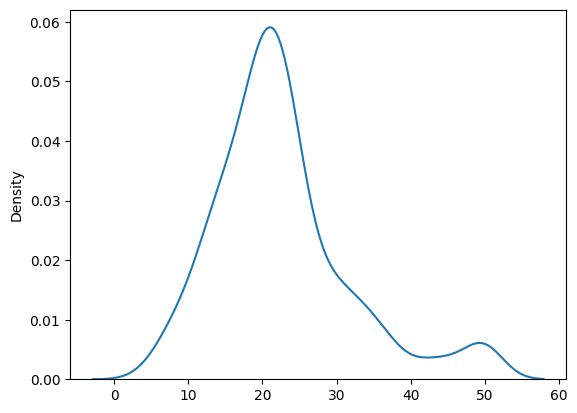

In [11]:
ppc = pm.sample_posterior_predictive(trace,  model=model)
sns.kdeplot(target, label='observed')
sns.kdeplot(ppc['y_obs'].mean(axis=0), label='predicted')
plt.legend()
plt.show()


In [13]:
new_data = np.array([0.1, 0, 10, 1, 0.5, 6, 50, 4, 4, 300, 15, 300, 10]).reshape(1, -1)
new_data = scaler.transform(new_data)

with model:
    # Predict
    y_new = pm.Normal('y_new', mu=pm.math.dot(new_data, beta)


SyntaxError: ignored

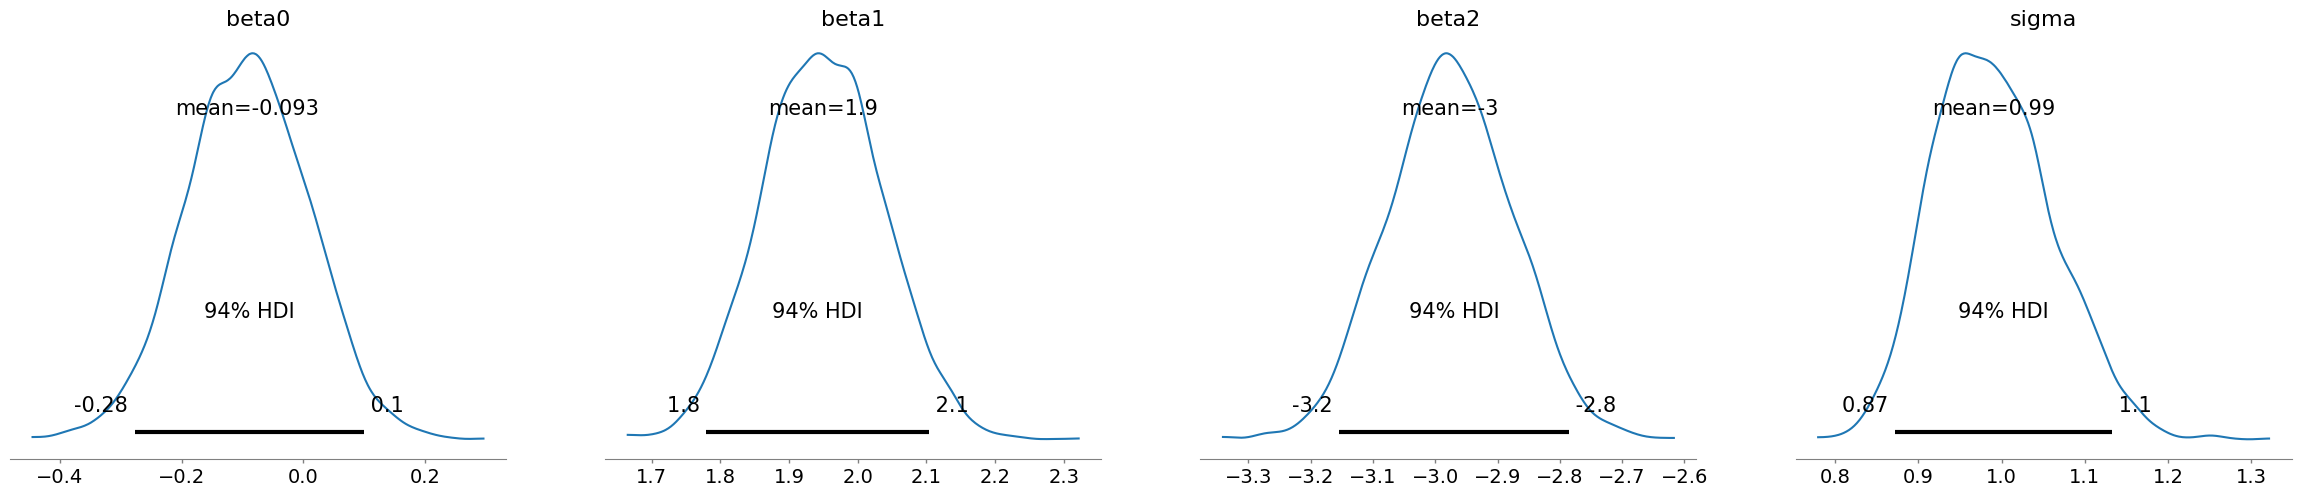

In [2]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt

# Generate some random data
np.random.seed(123)
N = 100
x1 = np.random.randn(N)
x2 = np.random.randn(N)
y = 2 * x1 - 3 * x2 + np.random.randn(N)

# Define the model
with pm.Model() as model:
    # Priors
    beta0 = pm.Normal('beta0', mu=0, sigma=10)
    beta1 = pm.Normal('beta1', mu=0, sigma=10)
    beta2 = pm.Normal('beta2', mu=0, sigma=10)
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Likelihood
    mu = beta0 + beta1 * x1 + beta2 * x2
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)

    # Inference
    trace = pm.sample(1000, chains=4)

# Summarize the results
pm.summary(trace)

# Plot the posterior distributions
pm.plot_posterior(trace)
plt.show()


In Bayesian statistics, the 94% HDI (Highest Density Interval) is an interval that contains 94% of the posterior probability density of a parameter.

In the case of Bayesian regression, if a 94% HDI is calculated for a regression coefficient (or slope), it means that there is a 94% probability that the true value of the coefficient lies within that interval.

For example, if we have a Bayesian regression model that predicts the salary of employees based on their years of experience, and we calculate a 94% HDI for the slope coefficient of the "years of experience" variable to be [0.5, 1.5], it means that there is a 94% probability that the true slope coefficient lies within this interval.

In other words, we are 94% confident that the true effect of the "years of experience" variable on salary falls within this range.

KeyError: ignored

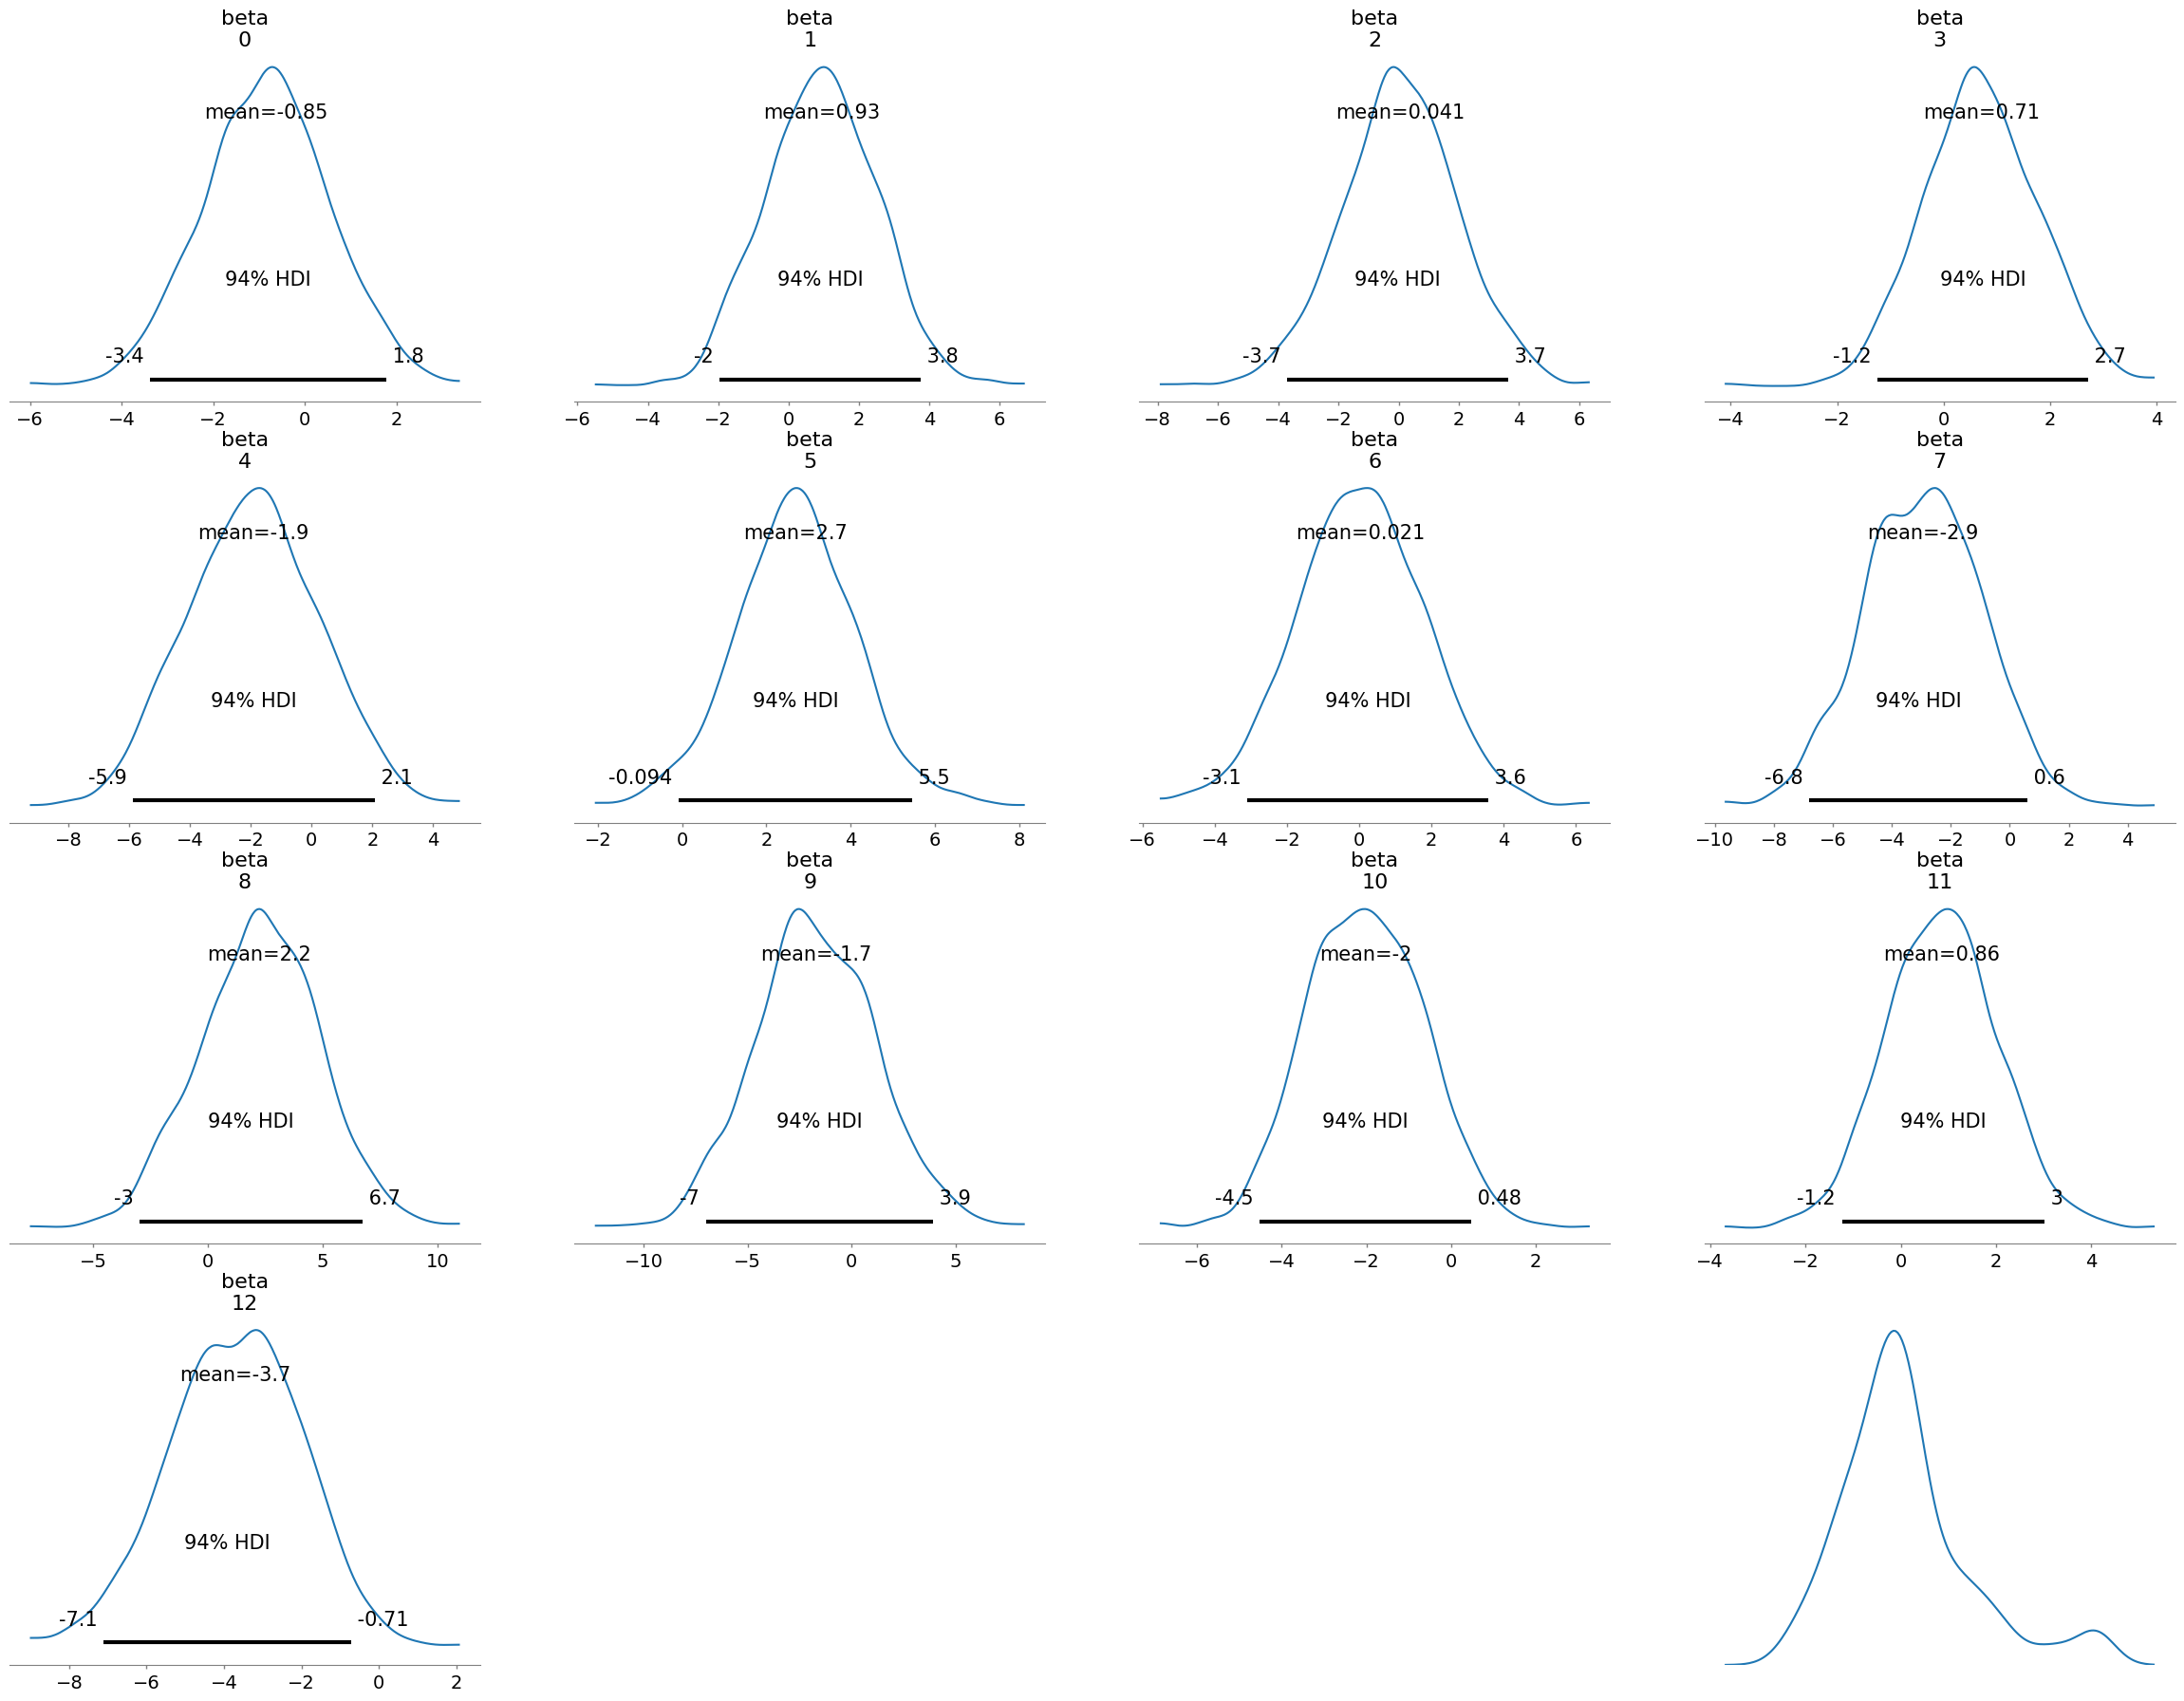

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
import pymc as pm

import pandas as pd
import numpy as np

data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

# Load the Boston Housing dataset
X = data
y = target

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Define the Bayesian linear regression model using PyMC3
with pm.Model() as model:
    # Priors for the regression coefficients
    beta = pm.Normal('beta', mu=0, sigma=10, shape=X.shape[1])
    # Prior for the noise variance
    sigma = pm.HalfNormal('sigma', sigma=10)
    # Expected value of the target variable
    mu = pm.math.dot(X, beta)
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=y)
    
    # Perform MCMC sampling
    trace = pm.sample(1000, tune=1000)

# Print summary statistics for the posterior distribution
pm.summary(trace)

# Plot the posterior distribution of the regression coefficients
pm.plot_posterior(trace, var_names=['beta'])

# Plot the posterior predictive distribution of the target variable
posterior_predictive = pm.sample_posterior_predictive(trace, model=model)
sns.kdeplot(y, label='Observed data')
for i in range(100):
    sns.kdeplot(posterior_predictive[Y_obs][i], alpha=0.1, color='red')
plt.xlabel('Price ($1000s)')
plt.ylabel('Density')
plt.legend()
plt.show()


BayesianRidge()
Model score (R-squared): 0.73
MSE: 26.69
RMSE: 5.17


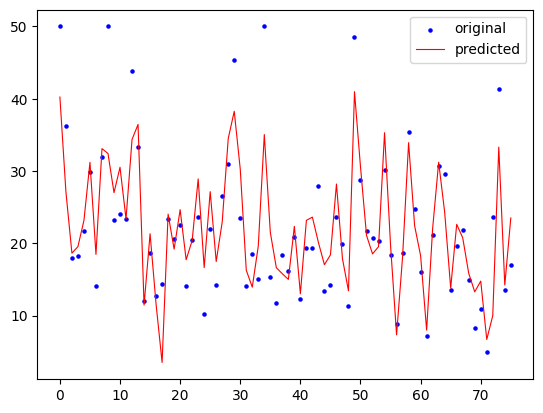

In [11]:
from sklearn.linear_model import BayesianRidge
#from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from numpy import sqrt

#boston = load_boston()
#x, y = boston.data, boston.target
xtrain, xtest, ytrain, ytest=train_test_split(X, y, test_size=0.15)

bay_ridge = BayesianRidge()
print(bay_ridge)
 
bay_ridge.fit(xtrain, ytrain)

score=bay_ridge.score(xtrain, ytrain)
print("Model score (R-squared): %.2f" % score)

ypred = bay_ridge.predict(xtest)
mse = mean_squared_error(ytest, ypred)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % sqrt(mse))

x_ax = range(len(ytest))
plt.scatter(x_ax, ytest, s=5, color="blue", label="original")
plt.plot(x_ax, ypred, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()
